In [47]:
import sys
import os
sys.path.append(os.path.expanduser('~/workspace/tacotron/'))

import argparse
from hparams import hparams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
from tacotron.alignment_synthesizer import AlignmentSynthesizer
from tacotron.pml_synthesizer import Configuration, PMLSynthesizer
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from util import audio

In [2]:
training_data_dir = '/media/josh/Store/tacotron-data/gran-lj-training'
metadata_filename = os.path.join(training_data_dir, 'test.txt')

cfg = Configuration(16000, 86)
synth = PMLSynthesizer(cfg)
# synth.load(checkpoint_path, hparams, gta=gta, model_name=args.variant)

with open(metadata_filename, encoding='utf-8') as f:
    metadata = [line.strip().split('|') for line in f]
    hours = sum((int(x[2]) for x in metadata)) * hparams.frame_shift_ms / (3600 * 1000)
    print('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))
    
pml_features = [m[3] for m in metadata]
texts = [m[5] for m in metadata]
wav_files = [m[6] for m in metadata]

Loaded metadata for 150 examples (0.68 hours)


In [214]:
FIGSIZE = (10, 6)
TARGET_INDEX = 26
texts[TARGET_INDEX]

'Also the Department requests the sum of one hundred thousand dollars to conduct a detailed feasibility study;'

In [4]:
fixed_sentence = texts[TARGET_INDEX]

# reset the graph before we do anything
tf.reset_default_graph()
synth = AlignmentSynthesizer()
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=86,spec_type=mcep')
synth.load('/media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000', hparams, model_name='tacotron_pml', locked_alignments=None)
first_alignment = synth.synthesize(fixed_sentence)  # of shape (encoder_steps, decoder_steps)

# reset the graph after the first synthesise call
tf.reset_default_graph()
hparams.parse('sample_rate=20000,frame_length_ms=50,frame_shift_ms=12.5,pml_dimension=86,spec_type=mcep')
synth.load('/media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000', hparams, model_name='tacotron_orig', locked_alignments=None)
second_alignment = synth.synthesize(fixed_sentence)

Constructing model: tacotron_pml
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  430
  decoder out (1 frame):   86
Loading checkpoint: /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000
Constructing model: tacotron_orig
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  400
  decoder out (1 frame):   80
  postnet out:             256
  linear out:              1025
Loading checkpoint: /media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000
INFO:tens

In [5]:
def show_alignment(alignment, label, ax, cmap=cm.cool, cutoff=220, scale_factor=1, norm=False):
    # normalise the alignment to scale from 0 to 1
    if norm:
        alignment = alignment / np.max(alignment)
    
    # set the background of the axis to black
    ax.set_facecolor('xkcd:black')
    
    cool = cmap(np.arange(cmap.N))
    # Set alpha
    cool[:, -1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    cool = ListedColormap(cool)
    # generate the image
    im_obj = Image.fromarray(np.uint8(cool(alignment) * 255))
    height, width = alignment.shape
    im_obj = im_obj.resize((round(width * scale_factor), height))
    im_obj = np.array(im_obj)[:, :cutoff]
    
    first_im = ax.imshow(
        im_obj,
        aspect='auto',
        origin='lower',
        interpolation='none')
    
    patch = mpatches.Patch(color=cool(0.8), label=label)
    
    xstep = 50
    outputs_per_step = 5
    frame_shift = 0.005
    plt.xticks(np.arange(0, 250, step=xstep),
               np.arange(0, 250 * frame_shift * outputs_per_step, step=frame_shift * outputs_per_step * xstep))
    plt.xlabel('Decoder Time (s)')
    plt.ylabel('Encoder Step (character index)')
    plt.tight_layout()
    
    return patch

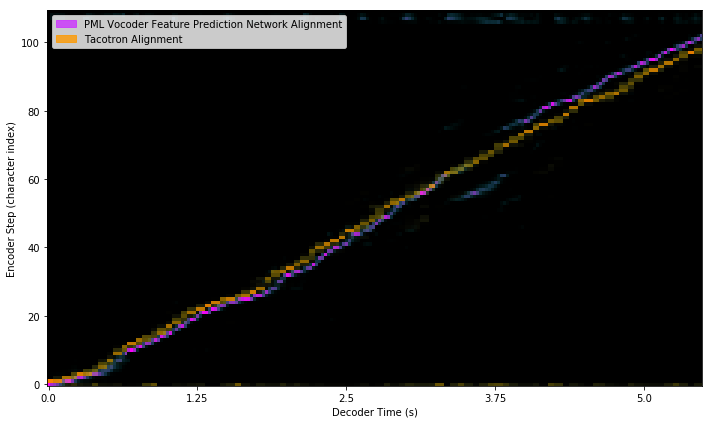

In [216]:
fig, ax = plt.subplots(figsize=FIGSIZE)

taco_pml_patch = show_alignment(first_alignment, 'PML Vocoder Feature Prediction Network Alignment', ax)
taco_patch = show_alignment(second_alignment, 'Tacotron Alignment', ax, cmap=cm.Wistia, scale_factor=12.5 / 5)
ax.legend(handles=[taco_pml_patch, taco_patch], loc='upper left')
plt.savefig('./TacotronAlignment/CompareAlignments.png', dpi=600)
plt.show()

In [40]:
from tacotron.synthesizer import Synthesizer
from util import audio

# reset the graph before we do anything
tf.reset_default_graph()
taco_synth = Synthesizer()
hparams.parse('sample_rate=20000,frame_length_ms=50,frame_shift_ms=12.5,pml_dimension=86,spec_type=mcep')
taco_synth.load('/media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000', model_name='tacotron_orig')
taco_orig_wav = taco_synth.synthesize(fixed_sentence, to_wav=True)[0]

Constructing model: tacotron_orig
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  400
  decoder out (1 frame):   80
  postnet out:             256
  linear out:              1025
Loading checkpoint: /media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000
Prepared Inputs


100%|██████████| 1/1 [00:00<00:00, 104.43it/s]


In [10]:
from lib import sigproc as sp
taco_orig_wav = taco_orig_wav[:audio.find_endpoint(taco_orig_wav)]
sp.wavwrite('./TacotronAlignment/taco_orig.wav', taco_orig_wav, 20000, norm_max_ifneeded=True)

In [13]:
vanilla_taco_wavs = []

for wav_file in tqdm(wav_files):  
    taco_wav_path = os.path.join(training_data_dir, 'vanilla_tacotron', wav_file)
    taco_wav, fs, _ = sp.wavread(taco_wav_path)
    vanilla_taco_wavs.append(taco_wav)

In [45]:
sp.wavwrite('./TacotronAlignment/taco_orig.wav', vanilla_taco_wavs[TARGET_INDEX], 20000, norm_max_ifneeded=True)

In [39]:
from tacotron.pml_synthesizer import Configuration, PMLSynthesizer
from lib import sigproc as sp

# reset the graph before we do anything
tf.reset_default_graph()
cfg = Configuration(16000, 86)
pml_synth = PMLSynthesizer(cfg)
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=86,spec_type=mcep')
pml_synth.load('/media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000', hparams, model_name='tacotron_pml')
wav_outputs = pml_synth.synthesize([fixed_sentence], to_wav=True, find_endpoint=True)

pml_wav = wav_outputs[0]
sp.wavwrite('./TacotronAlignment/taco_pml.wav', pml_wav, 16000, norm_max_ifneeded=True)

INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


In [64]:
# do analysis synthesis of the same sample
import shutil
shutil.copyfile(os.path.join(training_data_dir, 'analysis_synthesis', wav_files[TARGET_INDEX]), './TacotronAlignment/analysis_synthesis.wav')
shutil.copyfile(os.path.join(training_data_dir, 'wavs', wav_files[TARGET_INDEX]), './TacotronAlignment/ground_truth.wav')

'./TacotronAlignment/ground_truth.wav'

In [59]:
import librosa
taco_orig_wav = audio.load_wav('./TacotronAlignment/taco_orig.wav')
pml_wav = audio.load_wav('./TacotronAlignment/taco_pml.wav')
gt_wav = audio.load_wav('./TacotronAlignment/ground_truth.wav')
as_wav = audio.load_wav('./TacotronAlignment/analysis_synthesis.wav')

In [54]:
def rmse(first_set, second_set):
    error = 0.0
    wav_set_size = len(first_set)

    for i in range(wav_set_size):
        wav_1 = first_set[i]
        wav_2 = second_set[i]

        cutoff = min(len(wav_1), len(wav_2))
        error += np.mean(np.square(wav_1[:cutoff] - wav_2[:cutoff]))

    error = np.sqrt(error / wav_set_size)
    return error

In [44]:
taco_orig_wav_up = librosa.core.resample(taco_orig_wav, orig_sr=20000, target_sr=22050)
pml_wav_up = librosa.core.resample(pml_wav, orig_sr=16000, target_sr=22050)

In [65]:
# taco_orig_wav = vanilla_taco_wavs[TARGET_INDEX]
rmse([gt_wav], [taco_orig_wav])

0.07288545837571976

In [61]:
print(gt_wav.size, taco_orig_wav_up.size, pml_wav_up.size, as_wav.size) # as wav will have similar number of samples to ground truth

140624 145530 141120 140300


In [50]:
audio.save_wav(as_wav, './TacotronAlignment/out_as.wav')
audio.save_wav(gt_wav, './TacotronAlignment/out_gt.wav')
audio.save_wav(taco_orig_wav_up, './TacotronAlignment/out_taco.wav')
audio.save_wav(pml_wav_up, './TacotronAlignment/out_pml.wav')

In [62]:
rmse([gt_wav], [pml_wav])

0.10170353212361526

In [63]:
rmse([gt_wav], [as_wav])

0.15496995646273853

In [143]:
from util import audio

# reset the graph before we do anything
tf.reset_default_graph()
cfg = Configuration(16000, 86)
pml_synth = PMLSynthesizer(cfg)
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=86,spec_type=mcep')
pml_synth.load('/media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000', hparams, model_name='tacotron_pml')
wavs = []

for i in tqdm(np.arange(0, len(texts), 10)):
    wavs += pml_synth.synthesize(texts[i:i+10], to_wav=True, num_workers=5)

INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
    Forcing binary noise mask
    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask



In [155]:
from util import audio
from lib import sigproc as sp

taco_pml_dir = 'taco_pml_352k'
os.makedirs(os.path.join(training_data_dir, taco_pml_dir), exist_ok=True)
taco_pml_wavs_orig = np.copy(wavs)
taco_pml_wavs = []

for i, wav in enumerate(tqdm(taco_pml_wavs_orig)):
    wav = wav[:audio.find_endpoint(wav, threshold_db=0)]
    taco_pml_wavs.append(wav)
    sp.wavwrite(os.path.join(training_data_dir, taco_pml_dir, wav_files[i]), wav, 16000, norm_max_ifneeded=True)

In [161]:
from python_speech_features import mfcc

def mcd(set_1, set_2, sr_1=16000, sr_2=16000, nfft=4096, winlen=0.050, nfilt=52, numcep=26, base_sr=16000, debug=False):
    error = 0.0
    wav_set_size = len(set_1)

    for i in tqdm(range(wav_set_size)):
        wav_1 = set_1[i]
        wav_2 = set_2[i]
        
        if debug:
            print('Sample Rates:', sr_1, sr_2, base_sr)
        
        if sr_1 != base_sr:
            wav_1 = librosa.core.resample(wav_1, orig_sr=sr_1, target_sr=base_sr)
        
        if sr_2 != base_sr:
            wav_2 = librosa.core.resample(wav_2, orig_sr=sr_2, target_sr=base_sr)
        
        if debug:
            print('Wav Sizes:', len(wav_1), len(wav_2))
            
        cutoff = min(len(wav_1), len(wav_2))
        
        mfcc_1 = mfcc(wav_1[:cutoff], base_sr, nfft=nfft, winlen=winlen, nfilt=nfilt, numcep=numcep)
        mfcc_2 = mfcc(wav_2[:cutoff], base_sr, nfft=nfft, winlen=winlen, nfilt=nfilt, numcep=numcep)
        
        if debug:
            print('MFCC Lengths:', len(mfcc_1), len(mfcc_2))
            print()

        cutoff = min(len(mfcc_1), len(mfcc_2))
        sum_cepstral_error = np.sum(np.square(mfcc_1[:cutoff] - mfcc_2[:cutoff]), axis=1)
        error += np.mean(np.sqrt(sum_cepstral_error))

    error = np.sqrt(error / wav_set_size)
    return error

In [78]:
from util import audio
from lib import sigproc as sp
import librosa

gt_wavs = []
analysis_synthesis_wavs = []

for wav_file in tqdm(wav_files):
    gt_wav_path = os.path.join(training_data_dir, 'wavs', wav_file)
    gt_wav = audio.load_wav(gt_wav_path)
    gt_wav = librosa.core.resample(gt_wav, orig_sr=22050, target_sr=16000)
    gt_wavs.append(gt_wav)
    
    as_wav_path = os.path.join(training_data_dir, 'analysis_synthesis', wav_file)
    as_wav = audio.load_wav(as_wav_path)
    analysis_synthesis_wavs.append(as_wav)

In [177]:
from util import audio
from lib import sigproc as sp
import librosa

gt_wavs = []
analysis_synthesis_wavs = []

for wav_file in tqdm(wav_files):
    gt_wav_path = os.path.join(training_data_dir, 'wavs', wav_file)
    gt_wav, fs, _ = sp.wavread(gt_wav_path)
    gt_wavs.append(gt_wav)
    
    as_wav_path = os.path.join(training_data_dir, 'analysis_synthesis', wav_file)
    as_wav, fs, _ = sp.wavread(as_wav_path)
    analysis_synthesis_wavs.append(as_wav)

In [126]:
gt_wav_lens = [len(wav) for wav in gt_wavs]
as_wav_lens = [len(wav) for wav in analysis_synthesis_wavs]
min(gt_wav_lens), max(gt_wav_lens), min(as_wav_lens), max(as_wav_lens)

(25192, 161354, 24800, 160800)

In [203]:
vanilla_taco_wavs = []

for wav_file in tqdm(wav_files):  
    taco_wav_path = os.path.join(training_data_dir, 'vanilla_tacotron', wav_file)
    taco_wav, fs, _ = sp.wavread(taco_wav_path)
    vanilla_taco_wavs.append(taco_wav)

In [179]:
training_data_dir_163 = '/media/josh/Store/tacotron-data/163-lj-training'
analysis_synthesis_wavs_163 = []

for wav_file in tqdm(wav_files): 
    as_wav_path_163 = os.path.join(training_data_dir_163, 'analysis_synthesis_163', wav_file)
    as_wav_163, fs, _ = sp.wavread(as_wav_path_163)
    analysis_synthesis_wavs_163.append(as_wav_163)

In [180]:
mcd(gt_wavs, analysis_synthesis_wavs, sr_1=22050)

5.673569041525113

In [188]:
rmse(gt_wavs, analysis_synthesis_wavs)

0.13453807227940426

In [181]:
mcd(gt_wavs, analysis_synthesis_wavs_163, sr_1=22050)

5.73671805978629

In [186]:
rmse(gt_wavs, analysis_synthesis_wavs_163)

0.12880409250086736

In [182]:
mcd(gt_wavs, taco_pml_wavs, sr_1=22050)

10.060535112715472

In [185]:
rmse(gt_wavs, taco_pml_wavs)

0.12583205952028778

In [183]:
mcd(gt_wavs, vanilla_taco_wavs, sr_1=22050, sr_2=20000)

11.241195070528098

In [184]:
rmse(gt_wavs, vanilla_taco_wavs)

0.10084038456967537

LJ050-0155.wav
155037
112240
144000
108800


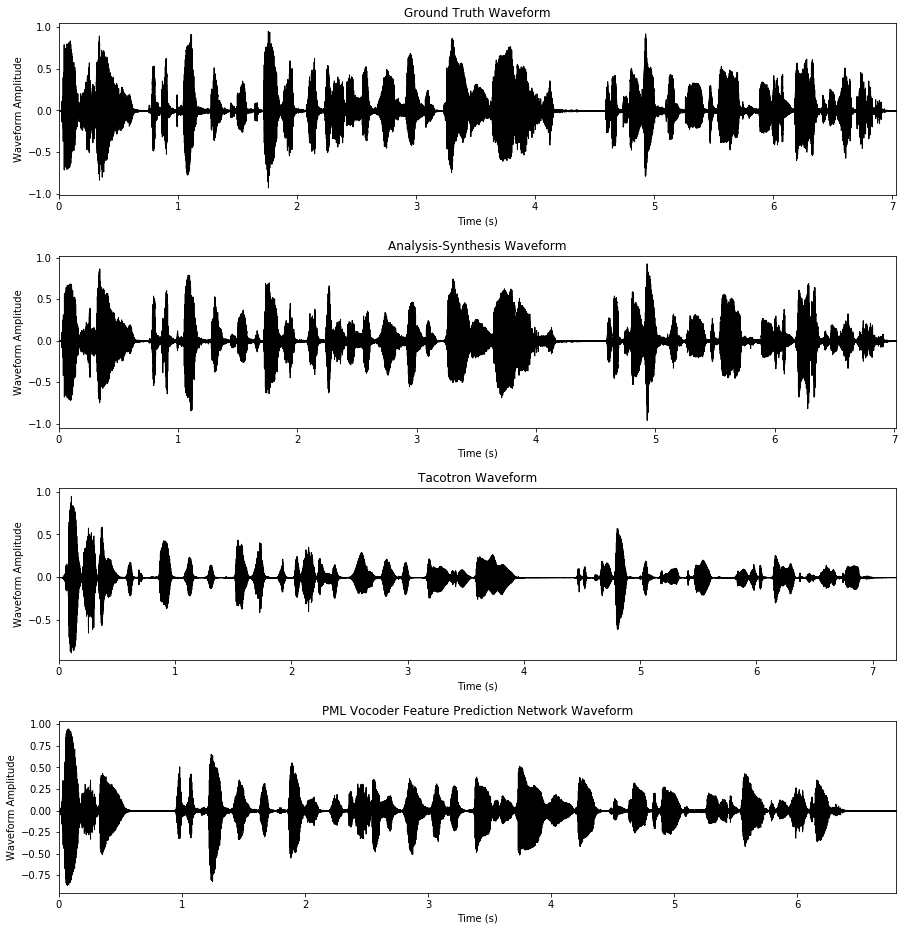

In [212]:
TARGET_INDEX = 26
print(wav_files[TARGET_INDEX])

# Make the plot
# You can tweak the figsize (width, height) in inches
plt.figure(figsize=(15, 16))

plt.subplot(4, 1, 1)
data = gt_wavs[TARGET_INDEX]
data /= 1.05 * np.max(np.abs(data))
print(len(data))
times = np.arange(len(data)) / float(22050)
plt.fill_between(times, data, color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('Time (s)')
plt.ylabel('Waveform Amplitude')
plt.title('Ground Truth Waveform')

plt.subplot(4, 1, 2)
data = analysis_synthesis_wavs[TARGET_INDEX]
data /= 1.05 * np.max(np.abs(data))
print(len(data))
times = np.arange(len(data)) / float(16000)
plt.fill_between(times, data, color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('Time (s)')
plt.ylabel('Waveform Amplitude')
plt.title('Analysis-Synthesis Waveform')

# plt.subplot(5, 1, 3)
# data = analysis_synthesis_wavs_163[TARGET_INDEX]
# print(len(data))
# times = np.arange(len(data)) / float(16000)
# plt.fill_between(times, data, color='k') 
# plt.xlim(times[0], times[-1])
# plt.xlabel('Time (s)')
# plt.ylabel('Waveform Amplitude')

plt.subplot(4, 1, 3)
data = vanilla_taco_wavs[TARGET_INDEX]
data /= 1.05 * np.max(np.abs(data))
print(len(data))
times = np.arange(len(data)) / float(20000)
plt.fill_between(times, data, color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('Time (s)')
plt.ylabel('Waveform Amplitude')
plt.title('Tacotron Waveform')

plt.subplot(4, 1, 4)
data = taco_pml_wavs[TARGET_INDEX]
data /= 1.05 * np.max(np.abs(data))
print(len(data))
times = np.arange(len(data)) / float(16000)
plt.fill_between(times, data, color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('Time (s)')
plt.ylabel('Waveform Amplitude')
plt.title('PML Vocoder Feature Prediction Network Waveform')

# You can set the format by changing the extension
# like .pdf, .svg, .eps
plt.subplots_adjust(hspace=0.35)
plt.savefig('./TacotronAlignment/Waveforms.png')
plt.show()